In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import List


def SIR_deterministic(beta : float,
                      mu : float, 
                      N : int, 
                      dt : float = 1.0, 
                      I0_frac : float = 0.01, 
                      T : int  = 100):
    I0 = int(N * I0_frac)
    S, I, R, t = [N - I0], [I0], [0], [0]
    for i in range(T):
        new_infected = (S[-1] * beta * I[-1] / N) * dt
        new_recovered = (I[-1] * mu) * dt
        S.append(S[-1] - new_infected)
        I.append(I[-1] + new_infected - new_recovered)
        R.append(R[-1] + new_recovered)
        t.append(t[-1] + dt)
    return np.array(S), np.array(I), np.array(R), np.array(t)


def SIR_stochastic(beta : float,
                   mu : float, 
                   N : int, 
                   dt : float = 1.0, 
                   I0_frac : float = 0.01, 
                   T : int  = 100):
    I0 = np.random.binomial(N, I0_frac)
    S, I, R, t = [N - I0], [I0], [0], [0]
    for i in range(T):
        new_infected = np.random.binomial(S[-1], beta * I[-1] / N * dt)
        new_recovered = np.random.binomial(I[-1], mu * dt)
        S.append(S[-1] - new_infected)
        I.append(I[-1] + new_infected - new_recovered)
        R.append(R[-1] + new_recovered)
        t.append(t[-1] + dt)
    return np.array(S), np.array(I), np.array(R),  np.array(t)


def wmape(arr1, arr2):
    """
    Weighted Mean Absolute Percentage Error (WMAPE)
    """
    return np.sum(np.abs(arr1 - arr2)) / np.sum(np.abs(arr1))

def ABC_rejection(Nsim : int, 
                  th : float, 
                  realI : List[float], 
                  params : dict):
    """
    This function runs a simple ABC rejection algorithm
    Parameters
    ----------
    - Nsim (int): total number of simulations to run 
    - th (float): acceptance/rejection threshold
    - realI (List[float]): list of actual number infected in time
    - params (dict): dictionary of model parameters

    Returns:
    - accepted parameters and sampled trajectories
    """
    accepted_params, sampledI = [], []
    for n in range(Nsim):
        beta = np.random.uniform(0.01, 0.6)
        S, I, R, t = SIR_stochastic(beta, **params)
        if wmape(realI, I) < th:
            accepted_params.append(beta)
            sampledI.append(I)
    return np.array(accepted_params), np.array(sampledI)


## ABC Rejection Algorithm

First, we generate the "ground truth" running the deterministic SIR model with given parameters:

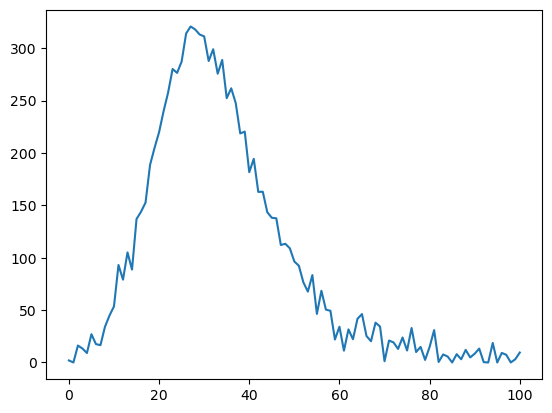

In [33]:
beta, mu, N = 0.3, 0.1, 10**3
S, I, R, t = SIR_deterministic(beta, mu, N)
# add random noise
I = I + np.random.normal(scale=10, size=(len(I)))
I[I < 0] = 0

plt.plot(I)

Second, we run the ABC rejection algorithm to find the posterior distribution of the "unknown" parameter $\beta$

In [ ]:
accepted_params, sampledI = ABC_rejection(100000, th=0.25, realI=I, params=dict(mu=mu, N=N))

Finally, we plot results:

In [ ]:
import seaborn as sns 

fig, axes = plt.subplots(dpi=300, figsize=(10,3), ncols=2)
sns.distplot(accepted_params, ax=axes[0], kde=False)
y1, y2 = axes[0].get_ylim()
axes[0].vlines(0.3, y1, y2, linestyle='--')
axes[0].set_title("Posterior Distribution")
axes[0].set_ylabel("$P(\\beta)$")
axes[0].set_xlabel("$\\beta$")

t = range(len(I))
p1, = axes[1].plot(t, np.median(sampledI, axis=0))
p2 = axes[1].fill_between(t, np.quantile(sampledI, axis=0, q=0.05), np.quantile(sampledI, axis=0, q=0.95), linewidth=0, alpha=0.3, zorder=-1)
p3 = axes[1].scatter(t, I, s=7, zorder=1)

axes[1].legend([(p1, p2), p3], ["median (90% CI)", "real"], frameon=False)
axes[1].set_ylabel("$I(t)$")
axes[1].set_xlabel("$t$")
axes[1].set_title("Ensemble Trajectories")
for ax in axes:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis="y", linestyle="--", alpha=0.6)

## ABC-SMC

We repeat the calibration step using the ABC-SMC algorithm. We will use the implementation of the ABC-SMC algorithm from the pyabc python package:

In [34]:
import pyabc 
from typing import Callable
from datetime import timedelta
from pyabc import RV, Distribution
import os 
import pickle as pkl
import uuid
from pyabc.sampler import MulticoreEvalParallelSampler
import seaborn as sns

In [35]:
def wmape_pyabc(sim_data : dict, actual_data : dict) -> float:
    return np.sum(np.abs(actual_data['data'] - sim_data['data'])) / np.sum(np.abs(actual_data['data']))

def ABCSMC_calibration(epimodel : Callable, 
                       prior : pyabc.Distribution, 
                       params : dict, 
                       distance : Callable,
                       observations : list,
                       transition : pyabc.AggregatedTransition,
                       max_walltime : timedelta = None,
                       population_size : int = 1000,
                       minimum_epsilon : float = 0.15, 
                       max_nr_populations : int = 10, 
                       run_name : str = '', 
                       run_id = None, 
                       n_procs : int = 8,
                       db = None, 
                       save_path : str = "./calibration_runs/") -> None:
    """
    Perform ABCSMC calibration for an epidemiological model.

    Parameters
    - epimodel (Callable): The epidemiological model function.
    - prior (pyabc.Distribution): The prior distribution for the model parameters.
    - params (dict): Additional fixed parameters required by the epidemiological model.
    - distance (Callable): The distance function used for comparing model simulations with observations.
    - observations (List[float]): The observed data for calibration.
    - transition (pyabc.AggregatedTransition): The transition object defining the ABCSMC transitions.
    - max_walltime (timedelta, optional): The maximum wall time for the calibration run. Defaults to None.
    - population_size (int, optional): The population size used in ABCSMC. Defaults to 1000.
    - minimum_epsilon (float, optional): The minimum epsilon value for the ABCSMC termination. Defaults to 0.15.
    - max_nr_populations (int, optional): The maximum number of populations in ABCSMC. Defaults to 10.
    - run_name (str, optional): The run_name to use for saving the calibration results. Defaults to ''.
    - run_id (Any, optional): The ID of the previous calibration run to load. Defaults to None.
    - n_procs (int, optional): Number of cores for parallel sampling.
    - db (Any, optional): The database connection object. Defaults to None.

    Returns:
    - None

    Raises:
    - None
    """
    
    def model(p): 
        S, I, R, t = epimodel(**p, **params)
        return {'data': I}

    if run_name == '':
        run_name = str(uuid.uuid4())

    # initialize ABC object
    abc = pyabc.ABCSMC(model, 
                       prior, 
                       distance, 
                       transitions=transition, 
                       population_size=population_size, 
                       sampler=MulticoreEvalParallelSampler(n_procs=n_procs))

    # check if this is a new calibration otherwise load previous calibration data
    if db == None:
        db_path = os.path.join(save_path, "dbs/", f"{run_name}.db")
        abc.new(f"sqlite:///{db_path}", {"data": observations})
    else:
        abc.load(db, run_id)
    
    # run calibration
    history = abc.run(minimum_epsilon=minimum_epsilon, 
                      max_nr_populations=max_nr_populations,
                      max_walltime=max_walltime)

    # save calibration logs, posteriors, and posterior samples 
    with open(os.path.join(save_path, "abc_history/", f"{run_name}.pkl"), 'wb') as file:
        pkl.dump(history, file)
    
    # save posterior distribution
    history.get_distribution()[0].to_csv(os.path.join(save_path, "posteriors/", f"{run_name}_posterior_distributions.csv"))  

    # compute quantiles and save samples
    raw_samples = np.array([d["data"] for d in history.get_weighted_sum_stats()[1]])
    np.savez_compressed(os.path.join(save_path, "posteriors/", f"{run_name}_posterior_samples.npz"), raw_samples)
    


In [36]:
ABCSMC_calibration(epimodel=SIR_stochastic, 
                   prior=Distribution(beta=RV("uniform", 0.1, 0.6 - 0.1), 
                                      mu=RV("uniform", 0.01, 0.2 - 0.01)), 
                   params={"N": N}, 
                   distance=wmape_pyabc,
                   observations=I,
                   transition=pyabc.AggregatedTransition(
                                                    mapping={
                                                        'beta': pyabc.MultivariateNormalTransition(),
                                                        'mu': pyabc.MultivariateNormalTransition()}),
                   run_name="ABC_SMC_test")

ABC.Sampler INFO: Parallelize sampling on 8 processes.
ABC.History INFO: Start <ABCSMC id=3, start_time=2023-07-22 17:34:36>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 8.31094325e-01.
ABC INFO: Accepted: 1000 / 2128 = 4.6992e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 6.04645106e-01.
ABC INFO: Accepted: 1000 / 2162 = 4.6253e-01, ESS: 9.5297e+02.
ABC INFO: t: 2, eps: 4.66580831e-01.
ABC INFO: Accepted: 1000 / 2340 = 4.2735e-01, ESS: 8.7643e+02.
ABC INFO: t: 3, eps: 3.50386505e-01.
ABC INFO: Accepted: 1000 / 2836 = 3.5261e-01, ESS: 8.3527e+02.
ABC INFO: t: 4, eps: 2.67662955e-01.
ABC INFO: Accepted: 1000 / 3196 = 3.1289e-01, ESS: 8.5978e+02.
ABC INFO: t: 5, eps: 2.14295566e-01.
ABC INFO: Accepted: 1000 / 3795 = 2.6350e-01, ESS: 7.7430e+02.
ABC INFO: t: 6, eps: 1.79177648e-01.
ABC INFO: Accepted: 1000 / 4947 = 2.0214e-01, ESS: 2.9721e+02.
ABC INFO: t: 7, eps: 1.51345043e-01.
ABC INFO: Accepted: 1000 / 7758 = 1.2890e-01, ESS: 8.1890e+02.
ABC INFO: t: 8, eps: 1.31784796e-01.
A

We look at the joint posterior distribution of the free parameters inferred via ABC-SMC:

In [37]:
posterior = pd.read_csv("./calibration_runs/posteriors/ABC_SMC_test_posterior_distributions.csv")
samples = np.load("./calibration_runs/posteriors/ABC_SMC_test_posterior_samples.npz")["arr_0"]

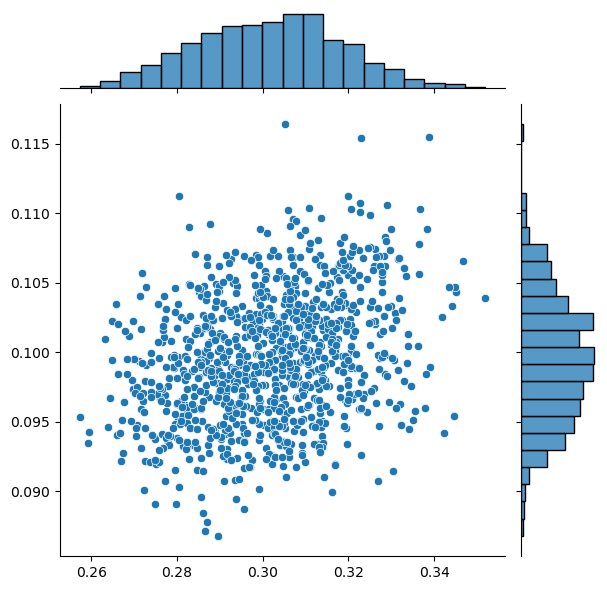

In [39]:
sns.jointplot(x=posterior.beta.values, y=posterior.mu.values)

We also plot the fitted number of infected over time respect to data:

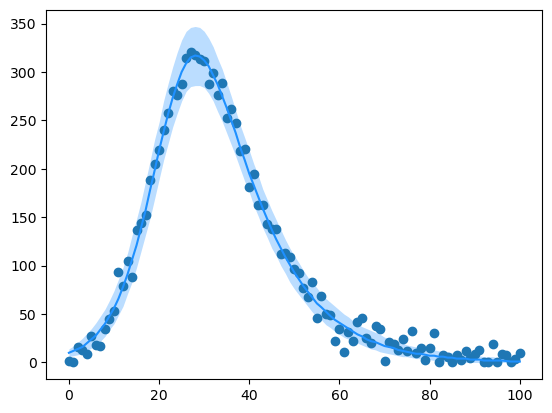

In [49]:
plt.plot(np.median(samples, axis=0), color="dodgerblue")
plt.fill_between(range(samples.shape[1]), np.quantile(samples, axis=0, q=0.05), np.quantile(samples, axis=0, q=0.95), color="dodgerblue", alpha=0.3, linewidth=0)
plt.scatter(range(samples.shape[1]), I)